<a href="https://colab.research.google.com/github/Rom1deTroyes/Segmentation_Lesions_Pulmonaires/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2Fcb4b9733-3fff-43d0-a1c7-e469e016b978.jpg&w=1280&q=75)

# Segmentation des lésions pulmonaires

Ce brief a pour objectif de manipuler une architecture CNN pour réaliser la segmentation.

Dans ce brief, nous appliquons un apprentissage supervisé pour détecter les lésions pulmonaires à partir d’une image.


In [3]:
!git clone https://github.com/Rom1deTroyes/Segmentation_Lesions_Pulmonaires  # clone
%cd Segmentation_Lesions_Pulmonaires
#%pip install -qr requirements.txt  # install

Cloning into 'Segmentation_Lesions_Pulmonaires'...
remote: Enumerating objects: 5481, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 5481 (delta 2), reused 9 (delta 2), pack-reused 5472
Receiving objects: 100% (5481/5481), 687.56 MiB | 31.24 MiB/s, done.
Resolving deltas: 100% (1729/1729), done.
Checking out files: 100% (5462/5462), done.
/content/Segmentation_Lesions_Pulmonaires


In [1]:
#!pip list --format=freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2022.5.18.1
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
di

In [4]:
import cv2
import os
import random

import numpy as np

from tqdm.notebook import tqdm

## Partie 1 : Base de données

### Charger les images

#### **Redimensionner** les images selon le modèle souhaité.

In [5]:
width=256
height=256

In [6]:
dir_img="frames/"
dir_mask="masks/"

tab_img=[]
tab_mask=[]

# Récupération de la liste des fichiers images
files = os.listdir(dir_img)
# Mélange des images 
random.Random(42).shuffle(files)

for n, i in tqdm(enumerate(files), total=len(files)):

    tab_img.append(cv2.resize(cv2.imread(dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)  # Image vide (h,w, N) avec N = nombre de classes
    img_mask_result[:,:,0][img_mask==255]=1.  ## Pour toutes les h,w de la profondeur 0 : Quand Couleur 255 (blanc) => Classe 1
    tab_mask.append(img_mask_result)

# Préparation du Tenseur
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

  0%|          | 0/2729 [00:00<?, ?it/s]

In [7]:
print(tab_img.shape)
print(tab_mask.shape)

(2729, 256, 256, 3)
(2729, 256, 256, 1)


#### Séparation des données en données d’apprentissage, validation et test.

In [8]:
val_num = 15/100
test_num = 20/100


In [9]:
val_split = int(1 - val_num * len(tab_img))

test_split = int(1 - test_num * (len(tab_img) - val_split))

print(val_split, test_split)

#split into training and testing
x_train = tab_img[0:test_split]
y_train = tab_mask[0:test_split]

x_test = tab_img[test_split:val_split]
y_test = tab_mask[test_split:val_split]

x_valid = tab_img[val_split:]
y_valid = tab_mask[val_split:]


print(x_train.shape, x_test.shape, x_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)


-408 -626
(2103, 256, 256, 3) (218, 256, 256, 3) (408, 256, 256, 3)
(2103, 256, 256, 1) (218, 256, 256, 1) (408, 256, 256, 1)


### Appliquer la data augmentation.

In [11]:
from keras.preprocessing import image

In [12]:
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# 0.9 = 90% Train + 10% Validation
tv_split = 0.9

# Apprentissage
seed = 42
image_datagen.fit(tab_img[:int(tab_img.shape[0]*tv_split)], augment=True, seed=seed)
mask_datagen.fit(tab_mask[:int(tab_mask.shape[0]*tv_split)], augment=True, seed=seed)

# Application de la Data Augmentation
BATCH_SIZE = 32
x=image_datagen.flow(tab_img[:int(tab_img.shape[0]*tv_split)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(tab_mask[:int(tab_mask.shape[0]*tv_split)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(tab_img[int(tab_img.shape[0]*tv_split):], augment=True, seed=seed)
mask_datagen_val.fit(tab_mask[int(tab_mask.shape[0]*tv_split):], augment=True, seed=seed)

x_val=image_datagen_val.flow(tab_img[int(tab_img.shape[0]*tv_split):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(tab_mask[int(tab_mask.shape[0]*tv_split):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

#### Autre façon de faire (Amine)



```python
Valid_dir_img="Data_Valid/Data/"
Valid_dir_mask="Data_Valid/Gr_Th/"

width=512
height=512
channels=3

Valid_tab_img=[]
Valid_tab_mask=[]

for n, i in tqdm(enumerate(os.listdir(Valid_dir_img)), total=len(os.listdir(Valid_dir_img))):
    Valid_tab_img.append(cv2.resize(cv2.imread(Valid_dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(Valid_dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)
    img_mask_result[:,:,0][img_mask==255]=1.
    Valid_tab_mask.append(img_mask_result)

tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

Valid_tab_img=np.array(Valid_tab_img)
Valid_tab_mask=np.array(Valid_tab_mask)

from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

seed = 42
image_datagen.fit(tab_img, augment=True, seed=seed)
mask_datagen.fit(tab_mask, augment=True, seed=seed)

BATCH_SIZE = 32
x=image_datagen.flow(tab_img,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(tab_mask,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(Valid_tab_img, augment=True, seed=seed)
mask_datagen_val.fit(Valid_tab_mask, augment=True, seed=seed)

x_val=image_datagen_val.flow(Valid_tab_img,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Valid_tab_mask,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)
```

### Visualiser les images de CT et sa vérité terrain (segmentation manuelle).

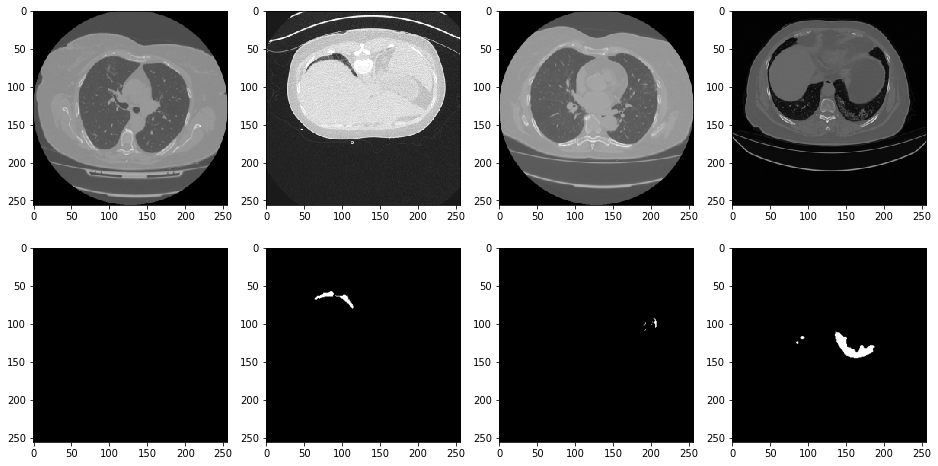

In [10]:
from matplotlib import pyplot as plt

n = 4
h = 4
f, axarr = plt.subplots(2,n, figsize=(h*n,2*h))

for c in range(n):
  r = c * int(len(tab_img)/(n-1))
  axarr[0,c].imshow(tab_img[r], interpolation='nearest')
  axarr[1,c].imshow(tab_mask[r,:,:,0], cmap='gray')


#plt.imshow(tab_img[42], interpolation='nearest')
#plt.show()

#plt.imshow(tab_mask[42,:,:,0], cmap='gray')
#plt.show()


## Partie 2 : Transfer Learning


### Préparation du modèle de segmentation

In [13]:
# Installation des bibliothèques
!pip install -q segmentation-models

     |████████████████████████████████| 50 kB 6.3 MB/s 


In [14]:
# Import des bibliothèques
import segmentation_models as sm
from segmentation_models import Unet

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [15]:
model_path = 'Unet_weights.h5'

#### Définition du modèle et des métriques

In [17]:
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'  # sigmoid si sortie binaire, sinon softmax

width=256
height=256

model = Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=(width, height, 3), activation=activation)  #  input_shape=(width, height, 3), 

# metrics = ["acc"]
metrics = ["acc", sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# compile keras model with defined optimozer, loss and metrics
model.compile('Adam', loss="binary_crossentropy", metrics=metrics)

# define callbacks for learning rate scheduling and best checkpoints saving
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    ReduceLROnPlateau(),
]


In [18]:
from keras.models import load_model
if os.path.exists(model_path) :
    model.load_weights(model_path)  # Rechargement du modèle si déjà enregistré

#### Apprentissage

In [19]:
EPOCHS = 1

results = model.fit_generator(train_generator,
                              steps_per_epoch=1000,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=500
                              )

model.save_weights(model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
1000/1000 [==============================] - 798s 776ms/step - loss: 0.0367 - acc: 0.9870 - val_loss: 0.0206 - val_acc: 0.9935
Epoch 2/10
1000/1000 [==============================] - 761s 762ms/step - loss: 0.0138 - acc: 0.9918 - val_loss: 0.0139 - val_acc: 0.9952
Epoch 3/10
1000/1000 [==============================] - 760s 760ms/step - loss: 0.0127 - acc: 0.9921 - val_loss: 0.0096 - val_acc: 0.9962
Epoch 4/10
1000/1000 [==============================] - 762s 762ms/step - loss: 0.0115 - acc: 0.9925 - val_loss: 0.0132 - val_acc: 0.9947
Epoch 5/10
1000/1000 [==============================] - 786s 787ms/step - loss: 0.0165 - acc: 0.9909 - val_loss: 0.0099 - val_acc: 0.9961
Epoch 6/10
1000/1000 [==============================] - 771s 771ms/step - loss: 0.0125 - acc: 0.9922 - val_loss: 0.0098 - val_acc: 0.9962
Epoch 7/10
1000/1000 [==============================] - 756s 756ms/step - loss: 0.0115 - acc: 0.9925 - val_loss: 0.0110 - val_acc: 0.9959
Epoch 8/10
 148/1000 [===>........

KeyboardInterrupt: ignored

In [20]:
model.save_weights(model_path)

#### Visualisation des métriques

NameError: ignored

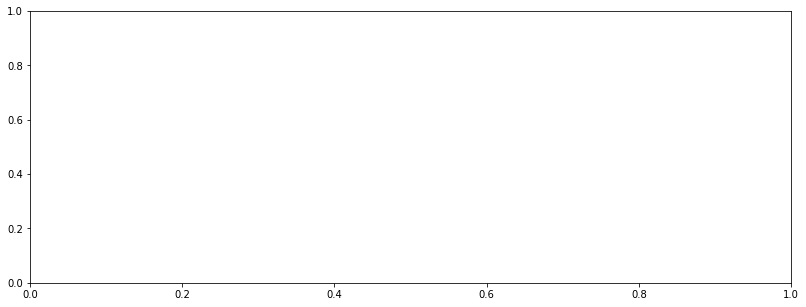

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['iou_score'])
plt.plot(results.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation Acc values
plt.subplot(122)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model Acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



- Aapplication d'un Transfer Learning sur l'architecture.

- F1-Score sur la base de test.

## Test

### Affichage de l'image détourée par son masque

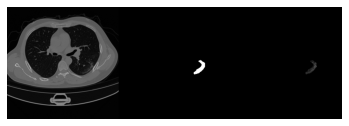

In [28]:
from PIL import Image

#width = height = 256

raw = Image.open('test.png')

raw = np.array(raw.resize((width, height)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

In [27]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Unet_weights.h5
	test.png

nothing added to commit but untracked files present (use "git add" to track)


In [20]:
!git diff